<a href="https://colab.research.google.com/github/abhishekydv14/privacy-preserving-fedrated-learning-using-HE/blob/main/PEMLP_implemantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.2 MB/s eta 0:00:00
Using device: cpu
Client batches per epoch-equivalent: 32
Total PFMLP comm_rounds for 20 epoch-equivalents: 640


100%|██████████| 9.91M/9.91M [00:00<00:00, 42.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]



--- Training Centralized MLP ---
Centralized MLP Epoch [4/20], Loss: 0.2151, Test Acc: 90.89%
Centralized MLP Epoch [8/20], Loss: 0.0977, Test Acc: 92.23%
Centralized MLP Epoch [12/20], Loss: 0.0438, Test Acc: 92.42%
Centralized MLP Epoch [16/20], Loss: 0.0181, Test Acc: 92.57%
Centralized MLP Epoch [20/20], Loss: 0.0078, Test Acc: 92.57%
Centralized MLP Training Time: 306.03 seconds

--- Training MLP Client 1 ---
MLP Client 1 Epoch [4/20], Loss: 0.2899, Test Acc: 88.11%
MLP Client 1 Epoch [8/20], Loss: 0.1467, Test Acc: 90.19%
MLP Client 1 Epoch [12/20], Loss: 0.0731, Test Acc: 90.20%
MLP Client 1 Epoch [16/20], Loss: 0.0413, Test Acc: 90.21%
MLP Client 1 Epoch [20/20], Loss: 0.0207, Test Acc: 90.38%
MLP Client 1 Training Time: 185.40 seconds

--- Training MLP Client 2 ---
MLP Client 2 Epoch [4/20], Loss: 0.2787, Test Acc: 89.03%
MLP Client 2 Epoch [8/20], Loss: 0.1489, Test Acc: 89.81%
MLP Client 2 Epoch [12/20], Loss: 0.0644, Test Acc: 90.24%
MLP Client 2 Epoch [16/20], Loss: 0.030

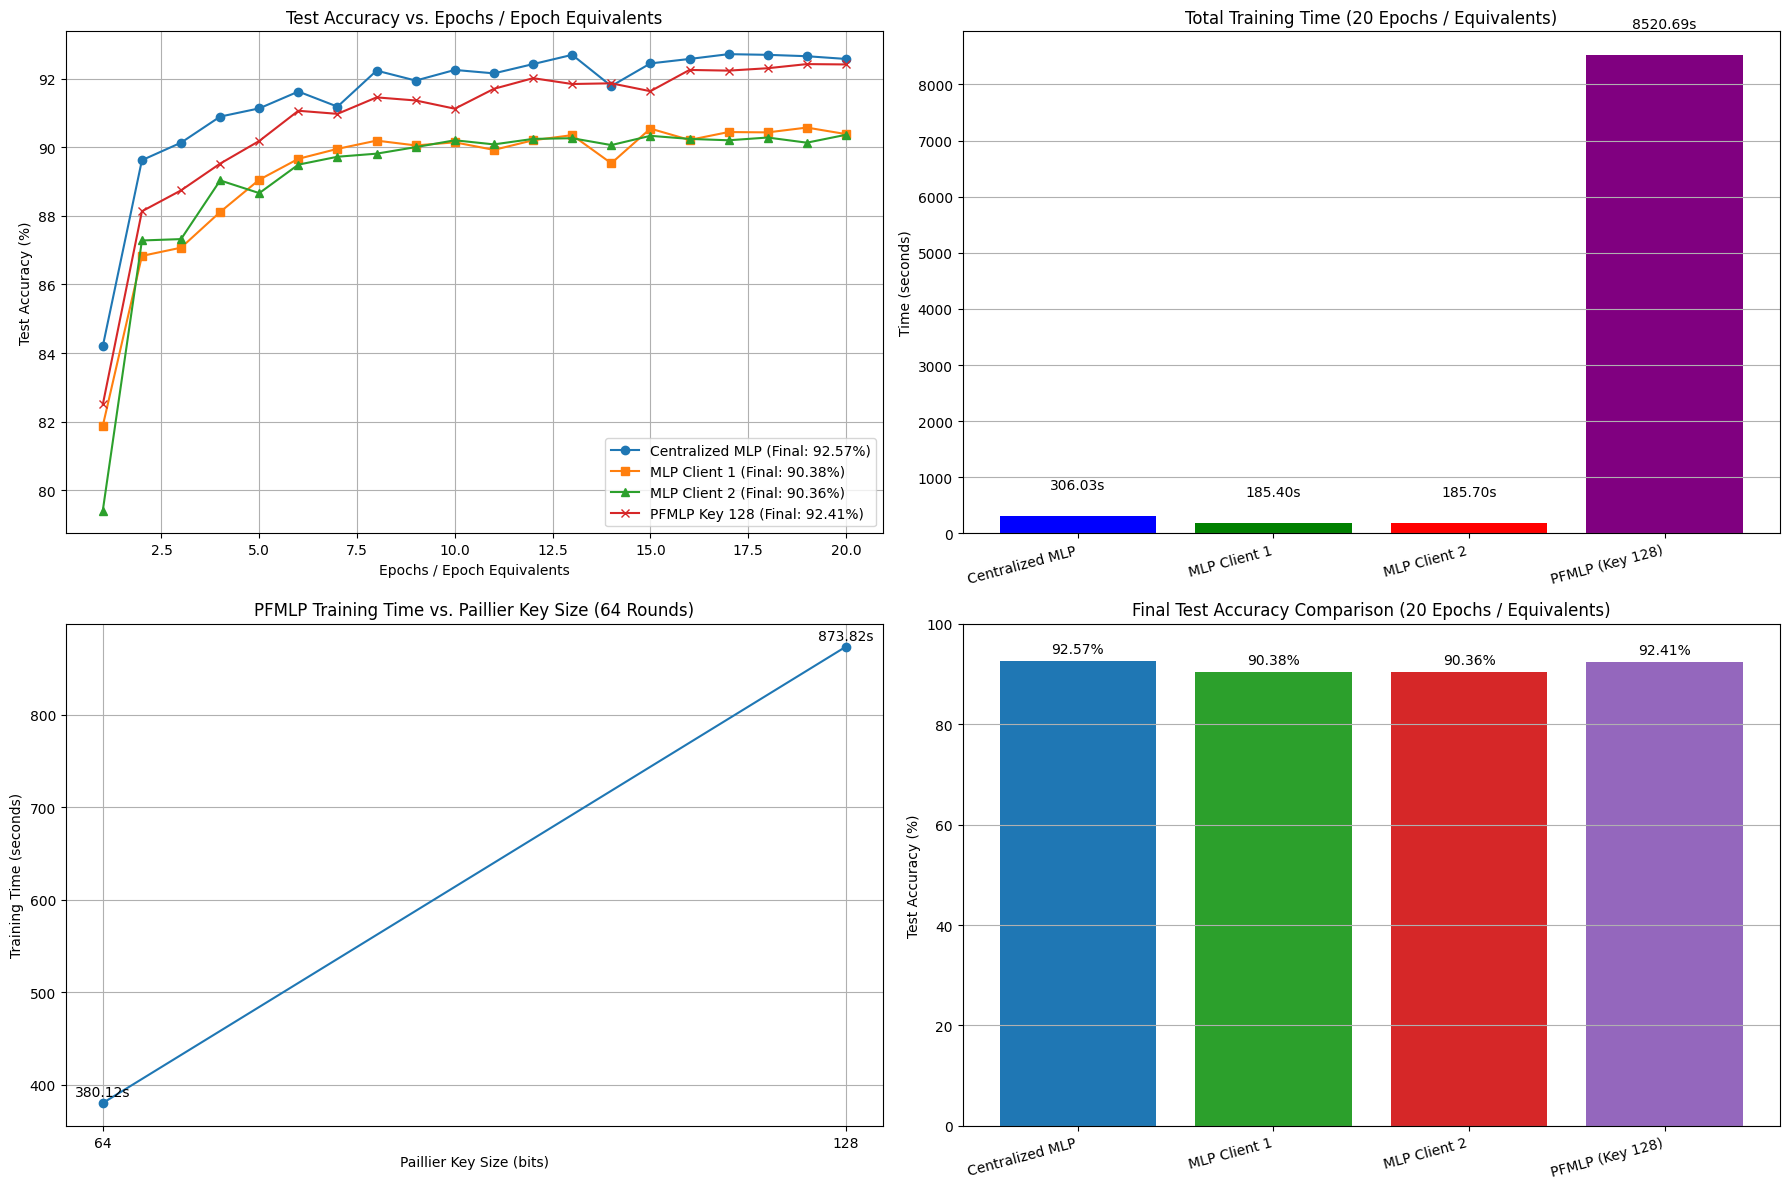


--- Final Accuracies (20 Epochs / Equivalents) ---
Centralized MLP: 92.57%
MLP Client 1: 90.38%
MLP Client 2: 90.36%
PFMLP (Key 128): 92.41%


In [ ]:

!pip install torch torchvision phe==1.5.0 matplotlib # Use 1.5.0 for potentially better float handling

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import copy
import matplotlib.pyplot as plt # For plotting

# Import Paillier
from phe import paillier

# --- 1. Setup & Configuration ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Model & Training Params
INPUT_SIZE = 784
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10
LEARNING_RATE = 0.001 # Slightly lower LR for Adam, can be tuned
BATCH_SIZE = 64
EPOCHS_MLP = 20      # Epochs for centralized & client MLPs (Increased for better MLP convergence)

# Data Params
N_TRAIN_SAMPLES = 4000
N_CLIENTS = 2
CLIENT_SAMPLES = N_TRAIN_SAMPLES // N_CLIENTS

# Paillier Key Sizes to Test for PFMLP Time Comparison
PFMLP_KEY_SIZES_FOR_TIMING = [64, 128] # Start small, can add 256 but it will be very slow
# Key size for the main PFMLP accuracy comparison run
PFMLP_KEY_SIZE_MAIN_RUN = 128

# --- Calculate PFMLP Communication Rounds to somewhat match MLP epochs ---
# Each client processes its entire local dataset once per "PFMLP epoch equivalent"
# Number of batches per client for one pass of their data:
CLIENT_BATCHES_PER_EPOCH = int(np.ceil(CLIENT_SAMPLES / BATCH_SIZE))
# Total communication rounds for PFMLP to see data `EPOCHS_MLP` times:
COMM_ROUNDS_PFMLP_EQUIVALENT = CLIENT_BATCHES_PER_EPOCH * EPOCHS_MLP # PFMLP clients do one batch per round
print(f"Client batches per epoch-equivalent: {CLIENT_BATCHES_PER_EPOCH}")
print(f"Total PFMLP comm_rounds for {EPOCHS_MLP} epoch-equivalents: {COMM_ROUNDS_PFMLP_EQUIVALENT}")


# --- 2. Data Loading & Preparation ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset_full = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
subset_indices_all = list(range(N_TRAIN_SAMPLES))
train_subset_all = Subset(train_dataset_full, subset_indices_all)
train_loader_mlp_central = DataLoader(train_subset_all, batch_size=BATCH_SIZE, shuffle=True)
client_loaders = []
indices_for_split = list(range(N_TRAIN_SAMPLES))
np.random.shuffle(indices_for_split)
client_actual_indices = []
for i in range(N_CLIENTS):
    client_split_indices = indices_for_split[i * CLIENT_SAMPLES : (i + 1) * CLIENT_SAMPLES]
    original_indices_for_client = [subset_indices_all[idx] for idx in client_split_indices]
    client_actual_indices.append(original_indices_for_client)
    client_dataset = Subset(train_dataset_full, original_indices_for_client)
    loader = DataLoader(client_dataset, batch_size=BATCH_SIZE, shuffle=True)
    client_loaders.append(loader)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# --- 3. Model Definition ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.view(x.size(0), -1); x = self.relu1(self.fc1(x));
        x = self.relu2(self.fc2(x)); x = self.fc3(x); return x

# --- 4. Evaluation Function ---
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 0 if total == 0 else (100 * correct / total)

# --- 5. Training Function (Reusable for MLPs, tracks accuracy per epoch) ---
def train_mlp_model(model, train_loader, test_loader, epochs, lr, device, model_name="Model"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy_history = []
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_acc = evaluate_model(model, test_loader, device)
        accuracy_history.append(epoch_acc)
        if (epoch + 1) % max(1, epochs // 5) == 0 or epoch == epochs -1 :
             print(f"{model_name} Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Acc: {epoch_acc:.2f}%")
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{model_name} Training Time: {training_time:.2f} seconds")
    return model, training_time, accuracy_history

# --- 6. PFMLP Helper Functions (Encryption/Decryption/Aggregation - Keeping as is) ---
def encrypt_gradients(gradients, public_key):
    encrypted_grads = []
    for grad_tensor in gradients:
        if grad_tensor is None: encrypted_grads.append(None); continue
        flat_grad = grad_tensor.cpu().numpy().flatten()
        encrypted_flat_grad = [public_key.encrypt(g.item(), precision=1e-5) for g in flat_grad]
        encrypted_grads.append((encrypted_flat_grad, grad_tensor.shape))
    return encrypted_grads

def decrypt_gradients(encrypted_grads, private_key):
    decrypted_grads = []
    for encrypted_data in encrypted_grads:
        if encrypted_data is None: decrypted_grads.append(None); continue
        encrypted_flat_grad, original_shape = encrypted_data
        dec_flat = [private_key.decrypt(g) for g in encrypted_flat_grad]
        dec_tensor = torch.tensor(dec_flat, dtype=torch.float32).view(original_shape)
        decrypted_grads.append(dec_tensor)
    return decrypted_grads

def aggregate_encrypted_gradients(encrypted_grad_list, public_key):
    if not encrypted_grad_list or len(encrypted_grad_list[0]) == 0 : return []
    num_layers = len(encrypted_grad_list[0])
    num_clients = len(encrypted_grad_list)
    aggregated_grads = [None] * num_layers
    for layer_idx in range(num_layers):
        first_valid_client_idx = -1
        for c_idx in range(num_clients):
            if encrypted_grad_list[c_idx] and encrypted_grad_list[c_idx][layer_idx] is not None:
                first_valid_client_idx = c_idx; break
        if first_valid_client_idx == -1: continue
        enc_data_init, original_shape = encrypted_grad_list[first_valid_client_idx][layer_idx]
        sum_encrypted_flat = list(enc_data_init)
        for client_idx in range(num_clients):
            if client_idx == first_valid_client_idx: continue
            if not encrypted_grad_list[client_idx] or encrypted_grad_list[client_idx][layer_idx] is None: continue
            enc_data_ci, _ = encrypted_grad_list[client_idx][layer_idx]
            if len(sum_encrypted_flat) != len(enc_data_ci): sum_encrypted_flat = None; break
            for i in range(len(sum_encrypted_flat)):
                if sum_encrypted_flat[i] is not None and enc_data_ci[i] is not None:
                    sum_encrypted_flat[i] += enc_data_ci[i]
                elif sum_encrypted_flat[i] is None and enc_data_ci[i] is not None:
                    sum_encrypted_flat[i] = enc_data_ci[i]
        if sum_encrypted_flat is not None:
            aggregated_grads[layer_idx] = (sum_encrypted_flat, original_shape)
    return aggregated_grads

# --- 7. PFMLP Training Function (Tracks accuracy per "epoch equivalent") ---
def train_pfmlp_model(model, client_loaders_list, test_loader, comm_rounds, client_batches_per_epoch_eq, lr, device, public_key, private_key, model_name="PFMLP"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizers = [optim.Adam(model.parameters(), lr=lr) for _ in range(len(client_loaders_list))] # One optimizer state per client for the shared model
    client_iterators = [iter(loader) for loader in client_loaders_list]
    accuracy_history = []
    print(f"\n--- Training {model_name} ---")
    start_time = time.time()
    enc_times_total, dec_times_total, agg_times_total = 0,0,0

    for round_num in range(comm_rounds):
        client_encrypted_grads = []
        client_losses = []
        model.train() # Ensure model is in training mode for each round

        for client_idx in range(len(client_loaders_list)):
            optimizer = optimizers[client_idx] # Get client specific optimizer state
            optimizer.zero_grad()
            try: data, target = next(client_iterators[client_idx])
            except StopIteration:
                client_iterators[client_idx] = iter(client_loaders_list[client_idx])
                data, target = next(client_iterators[client_idx])
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data); loss = criterion(outputs, target); loss.backward()
            client_losses.append(loss.item())
            with torch.no_grad(): current_grads = [p.grad.detach().clone() if p.grad is not None else None for p in model.parameters()]

            s_enc = time.time(); enc_grads = encrypt_gradients(current_grads, public_key); enc_times_total += (time.time() - s_enc)
            client_encrypted_grads.append(enc_grads)
            optimizer.zero_grad() # Clear grads on shared model after extraction for this client

        s_agg = time.time(); agg_enc_grad = aggregate_encrypted_gradients(client_encrypted_grads, public_key); agg_times_total += (time.time() - s_agg)

        if agg_enc_grad and any(g is not None for g in agg_enc_grad): # Check if any gradient was aggregated
            s_dec = time.time(); dec_agg_grad = decrypt_gradients(agg_enc_grad, private_key); dec_times_total += (time.time() - s_dec)
            optimizer_global = optimizers[0] # Use one optimizer to apply update
            optimizer_global.zero_grad()
            with torch.no_grad():
                valid_grads_applied = 0
                for i, param in enumerate(model.parameters()):
                    if param.requires_grad and i < len(dec_agg_grad) and dec_agg_grad[i] is not None:
                        avg_grad = dec_agg_grad[i].to(DEVICE) / len(client_loaders_list)
                        param.grad = avg_grad; valid_grads_applied+=1
                    else: param.grad = None
            if valid_grads_applied > 0: optimizer_global.step()

        # Evaluate and store accuracy at the end of each "epoch equivalent"
        if (round_num + 1) % client_batches_per_epoch_eq == 0 or round_num == comm_rounds - 1:
            epoch_eq = (round_num + 1) // client_batches_per_epoch_eq
            epoch_acc = evaluate_model(model, test_loader, device)
            accuracy_history.append(epoch_acc)
            avg_loss = sum(client_losses) / len(client_losses) if client_losses else 0
            print(f"{model_name} Epoch-Eq [{epoch_eq}/{comm_rounds//client_batches_per_epoch_eq}], Round [{round_num+1}/{comm_rounds}], Loss: {avg_loss:.4f}, Test Acc: {epoch_acc:.2f}%")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"{model_name} Training Time: {training_time:.2f} seconds")
    print(f"Avg Encryption time per round: {enc_times_total/comm_rounds if comm_rounds > 0 else 0:.4f}s")
    print(f"Avg Aggregation time per round: {agg_times_total/comm_rounds if comm_rounds > 0 else 0:.4f}s")
    print(f"Avg Decryption time per round: {dec_times_total/comm_rounds if comm_rounds > 0 else 0:.4f}s")
    return model, training_time, accuracy_history

# --- 8. Run MLP Experiments ---
mlp_central_model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
_, time_mlp_central, acc_hist_mlp_central = train_mlp_model(
    mlp_central_model, train_loader_mlp_central, test_loader, EPOCHS_MLP, LEARNING_RATE, DEVICE, "Centralized MLP"
)

mlp_client1_model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
_, time_mlp_client1, acc_hist_mlp_client1 = train_mlp_model(
    mlp_client1_model, client_loaders[0], test_loader, EPOCHS_MLP, LEARNING_RATE, DEVICE, "MLP Client 1"
)

mlp_client2_model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
_, time_mlp_client2, acc_hist_mlp_client2 = train_mlp_model(
    mlp_client2_model, client_loaders[1], test_loader, EPOCHS_MLP, LEARNING_RATE, DEVICE, "MLP Client 2"
)

# --- 9. Run Main PFMLP Experiment ---
print(f"\n--- Running Main PFMLP with Key Size: {PFMLP_KEY_SIZE_MAIN_RUN} ---")
main_pk, main_sk = paillier.generate_paillier_keypair(n_length=PFMLP_KEY_SIZE_MAIN_RUN)
pfmlp_main_model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
_, time_pfmlp_main, acc_hist_pfmlp_main = train_pfmlp_model(
    pfmlp_main_model, client_loaders, test_loader, COMM_ROUNDS_PFMLP_EQUIVALENT, CLIENT_BATCHES_PER_EPOCH,
    LEARNING_RATE, DEVICE, main_pk, main_sk, f"PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN})"
)

# --- 10. PFMLP Training Time vs. Key Size ---
pfmlp_key_times = {}
# For timing, use fewer rounds to make it faster
TIMING_COMM_ROUNDS = CLIENT_BATCHES_PER_EPOCH * 2 # Equivalent of 2 epochs for timing test

print("\n--- PFMLP Training Time vs. Key Size (2 Epoch Equivalents) ---")
for key_len in PFMLP_KEY_SIZES_FOR_TIMING:
    print(f"Testing PFMLP with Key Size: {key_len}")
    pk, sk = paillier.generate_paillier_keypair(n_length=key_len)
    pfmlp_timing_model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE) # Fresh model
    # We only care about time, not final accuracy here for this specific test
    _, pfmlp_t_time, _ = train_pfmlp_model(
        pfmlp_timing_model, client_loaders, test_loader, TIMING_COMM_ROUNDS, CLIENT_BATCHES_PER_EPOCH,
        LEARNING_RATE, DEVICE, pk, sk, f"PFMLP Timing (Key {key_len})"
    )
    pfmlp_key_times[key_len] = pfmlp_t_time



# --- 11. Plotting ---
plt.figure(figsize=(18, 12)) # Increased figure size slightly for 4 plots

# Plot 1: Accuracy vs. Epochs
plt.subplot(2, 2, 1)
plt.plot(range(1, EPOCHS_MLP + 1), acc_hist_mlp_central, marker='o', label=f'Centralized MLP (Final: {acc_hist_mlp_central[-1]:.2f}%)')
plt.plot(range(1, EPOCHS_MLP + 1), acc_hist_mlp_client1, marker='s', label=f'MLP Client 1 (Final: {acc_hist_mlp_client1[-1]:.2f}%)')
plt.plot(range(1, EPOCHS_MLP + 1), acc_hist_mlp_client2, marker='^', label=f'MLP Client 2 (Final: {acc_hist_mlp_client2[-1]:.2f}%)')
if acc_hist_pfmlp_main: # Check if PFMLP main run produced history
    pfmlp_epochs_x_axis = range(1, len(acc_hist_pfmlp_main) + 1)
    plt.plot(pfmlp_epochs_x_axis, acc_hist_pfmlp_main, marker='x', label=f'PFMLP Key {PFMLP_KEY_SIZE_MAIN_RUN} (Final: {acc_hist_pfmlp_main[-1]:.2f}%)')
plt.title('Test Accuracy vs. Epochs / Epoch Equivalents')
plt.xlabel('Epochs / Epoch Equivalents')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot 2: Training Times Comparison
plt.subplot(2, 2, 2)
models_time = ['Centralized MLP', 'MLP Client 1', 'MLP Client 2', f'PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN})']
times_value = [time_mlp_central, time_mlp_client1, time_mlp_client2, time_pfmlp_main]
bars_time = plt.bar(models_time, times_value, color=['blue', 'green', 'red', 'purple'])
plt.title(f'Total Training Time ({EPOCHS_MLP} Epochs / Equivalents)')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=15, ha="right")
for bar in bars_time: # Add time values on top of bars
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05 * max(times_value, default=1), f'{yval:.2f}s', ha='center', va='bottom') # Added default to max
plt.grid(axis='y')


# Plot 3: PFMLP Training Time vs. Key Size
plt.subplot(2, 2, 3)
if pfmlp_key_times:
    key_sizes_plot = sorted(pfmlp_key_times.keys())
    times_plot = [pfmlp_key_times[k] for k in key_sizes_plot]
    plt.plot(key_sizes_plot, times_plot, marker='o', linestyle='-')
    plt.title(f'PFMLP Training Time vs. Paillier Key Size ({TIMING_COMM_ROUNDS} Rounds)')
    plt.xlabel('Paillier Key Size (bits)')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(key_sizes_plot) # Ensure all tested key sizes are ticks
    for i, txt in enumerate(times_plot):
        plt.annotate(f'{txt:.2f}s', (key_sizes_plot[i], times_plot[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'PFMLP Key Timing Data Not Available', ha='center', va='center', transform=plt.gca().transAxes)


# Plot 4: Final Accuracy Comparison (MLP vs PFMLP) - NEW PLOT
plt.subplot(2, 2, 4)
model_names_acc_final = ['Centralized MLP', 'MLP Client 1', 'MLP Client 2']
accuracies_final = [acc_hist_mlp_central[-1], acc_hist_mlp_client1[-1], acc_hist_mlp_client2[-1]]

# Add PFMLP only if its history exists (meaning it ran successfully)
if acc_hist_pfmlp_main:
    model_names_acc_final.append(f'PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN})')
    accuracies_final.append(acc_hist_pfmlp_main[-1])
else: # If PFMLP data is missing, we can add a placeholder or skip
    model_names_acc_final.append(f'PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN})')
    accuracies_final.append(0) # Or some other indicator for missing data
    print("WARN: PFMLP accuracy history not found for final accuracy plot.")


bars_acc = plt.bar(model_names_acc_final, accuracies_final, color=['#1f77b4', '#2ca02c', '#d62728', '#9467bd']) # Using default matplotlib colors
plt.title(f'Final Test Accuracy Comparison ({EPOCHS_MLP} Epochs / Equivalents)')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100) # Set y-axis limit for accuracy
plt.xticks(rotation=15, ha="right")
for bar in bars_acc:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')
plt.grid(axis='y')


plt.tight_layout()
plt.show()

# --- Final Summary Print ---
print(f"\n--- Final Accuracies ({EPOCHS_MLP} Epochs / Equivalents) ---")
print(f"Centralized MLP: {acc_hist_mlp_central[-1]:.2f}%")
print(f"MLP Client 1: {acc_hist_mlp_client1[-1]:.2f}%")
print(f"MLP Client 2: {acc_hist_mlp_client2[-1]:.2f}%")
if acc_hist_pfmlp_main:
    print(f"PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN}): {acc_hist_pfmlp_main[-1]:.2f}%")
else:
    print(f"PFMLP (Key {PFMLP_KEY_SIZE_MAIN_RUN}): Data not available")